<a href="https://colab.research.google.com/github/abarb2022/Walmart-Recruiting---Store-Sales-Forecasting/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading Kaggle data sets directly into Colab**

Install the kaggle python library

In [ ]:
! pip install kaggle

Mount the Google drive so you can store your kaggle API credentials for future use

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a directory for kaggle at the temporary instance location on Colab drive.

Download your kaggle API key (.json file). You can do this by going to your kaggle account page and clicking 'Create new API token' under the API section.

In [ ]:
! mkdir ~/.kaggle

Upload the json file to Google Drive and then copy to the temporary location.

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

**1. Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [ ]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 653MB/s]


Unzip, in case the downloaded file is zipped. Refresh the files on the left hand side to update the view.

In [ ]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder # For Type encoding if not using category dtype directly
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import gc # For garbage collection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [ ]:

stores = pd.read_csv('stores.csv')
train = pd.read_csv("train.csv.zip")
features = pd.read_csv('features.csv.zip')
sample = pd.read_csv('sampleSubmission.csv.zip')
test = pd.read_csv('test.csv.zip')

In [ ]:
# Convert 'Date' columns to datetime objects for easier manipulation
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge features with train and test data.
# Note: 'IsHoliday' is present in both train/test and features.csv.
# We'll merge on it to ensure consistency, but if there were discrepancies,
# we'd need a more careful merge strategy.
train = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Merge store information
train = pd.merge(train, stores, on='Store', how='left')

print("\n--- Merged Train Data Head ---")
print(train.head())


print("\n--- Merged Train Data Info ---")
print(train.info())





--- Merged Train Data Head ---
   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type    Size
0      1     1 2010-02-05      24924.50      False        42.31       2.572        NaN        NaN        NaN        NaN        NaN  211.096358         8.106    A  151315
1      1     1 2010-02-12      46039.49       True        38.51       2.548        NaN        NaN        NaN        NaN        NaN  211.242170         8.106    A  151315
2      1     1 2010-02-19      41595.55      False        39.93       2.514        NaN        NaN        NaN        NaN        NaN  211.289143         8.106    A  151315
3      1     1 2010-02-26      19403.54      False        46.63       2.561        NaN        NaN        NaN        NaN        NaN  211.319643         8.106    A  151315
4      1     1 2010-03-05      21827.90      False        46.50       2.625        NaN        NaN        NaN        Na

# **Over the 2.5-year period, total weekly sales fluctuate seasonally but do not follow a strong upward or downward long-term trend.**

ყოველკვირეული გაყიდვები აშკარა სეზონურ რყევებს განიცდის, მაგრამ გრძელვადიანი ტენდენცია არ ჩანს 2.5-წლიან პერიოდში. ეს მიუთითებს მონაცემების სტაციონარულობაზე, რაც time series მოდელირებისთვის ხელსაყრელია.


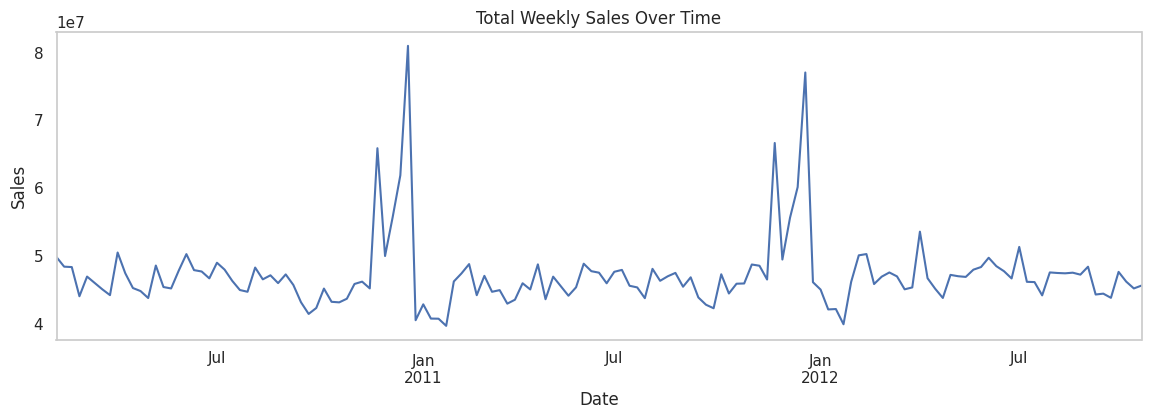

In [ ]:
weekly_sales = train.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(14, 4))
weekly_sales.plot()
plt.title("Total Weekly Sales Over Time")
plt.ylabel("Sales")
plt.grid()
plt.show()



# **Despite some scale differences, the sales pattern is very consistent across stores, indicating synchronized behavior (likely due to national promotions or shared seasonal effects).**

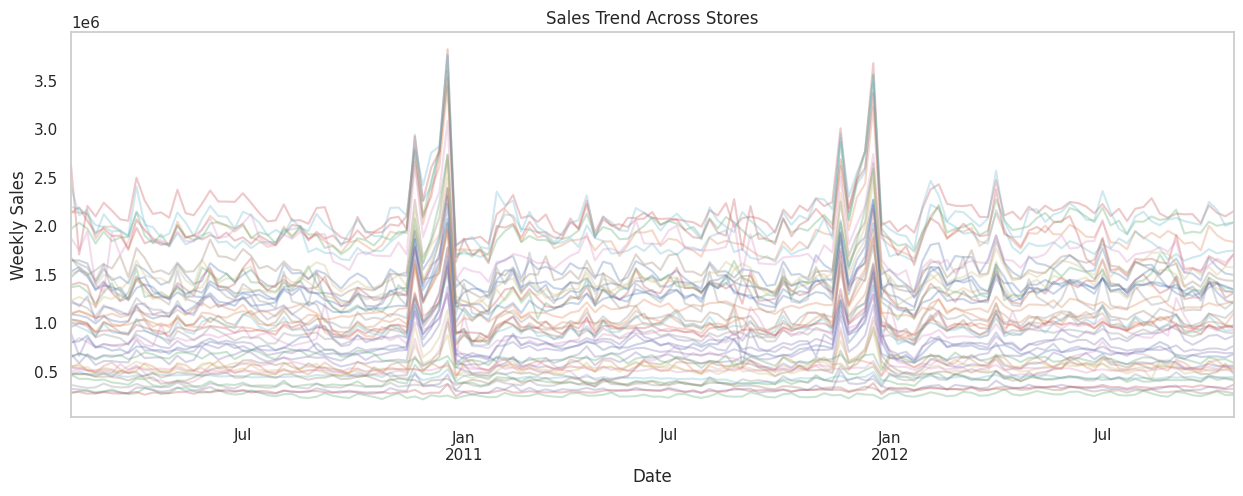

In [ ]:
store_sales = train.groupby(['Date', 'Store'])['Weekly_Sales'].sum().reset_index()
pivoted = store_sales.pivot(index='Date', columns='Store', values='Weekly_Sales')

pivoted.plot(figsize=(15, 5), alpha=0.3, legend=False)
plt.title("Sales Trend Across Stores")
plt.ylabel("Weekly Sales")
plt.grid()
plt.show()


# **Christmas is the most consistent and significant peak in the entire dataset — confirming its importance in modeling.**

ყველაზე მნიშვნელოვანი გაყიდვების პიკი შობასთან არის დაკავშირებული. დღესასწაულების კვირებში გაყიდვების განაწილება მკვეთრად განსხვავდება ჩვეულებრივი კვირებისგან. ამიტომ შობის ეფექტი შეიძლება იყოს რეგრესორი time-series მოდელებში.

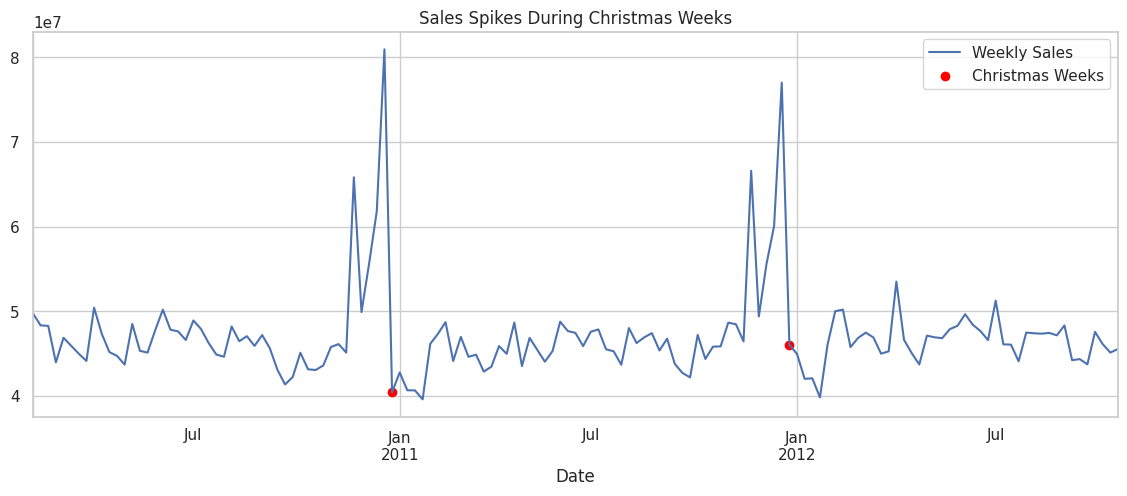

In [ ]:
# Use holiday weeks
holiday_weeks = ['2010-12-31', '2011-12-30']
holiday_weeks = pd.to_datetime(holiday_weeks)

plt.figure(figsize=(14, 5))
weekly_sales.plot(label="Weekly Sales")
plt.scatter(holiday_weeks, weekly_sales.loc[holiday_weeks], color='red', label='Christmas Weeks')
plt.title("Sales Spikes During Christmas Weeks")
plt.legend()
plt.show()


# **Outside of the holiday weeks, sales remain relatively stable with less variation — helpful for establishing a reliable baseline in time-series models.**

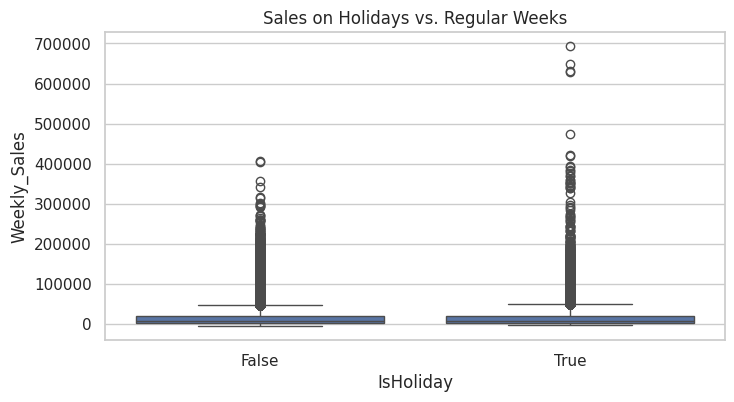

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=train)
plt.title("Sales on Holidays vs. Regular Weeks")
plt.show()


# **Departments (e.g., groceries or pharmacy) behave very similarly across different stores, suggesting shared consumer patterns.**

დეპარტამენტები სხვადასხვა მაღაზიებში მსგავს შედეგებს დებენ უმეტესად,, რაც მიუთითებს, რომ მომხმარებლების ქცევაზე უფრო დროითი ფაქტორები (სეზონი, დღესასწაულები) მოქმედებს, ვიდრე კონკრეტული მაღაზიის მახასიათებლები.

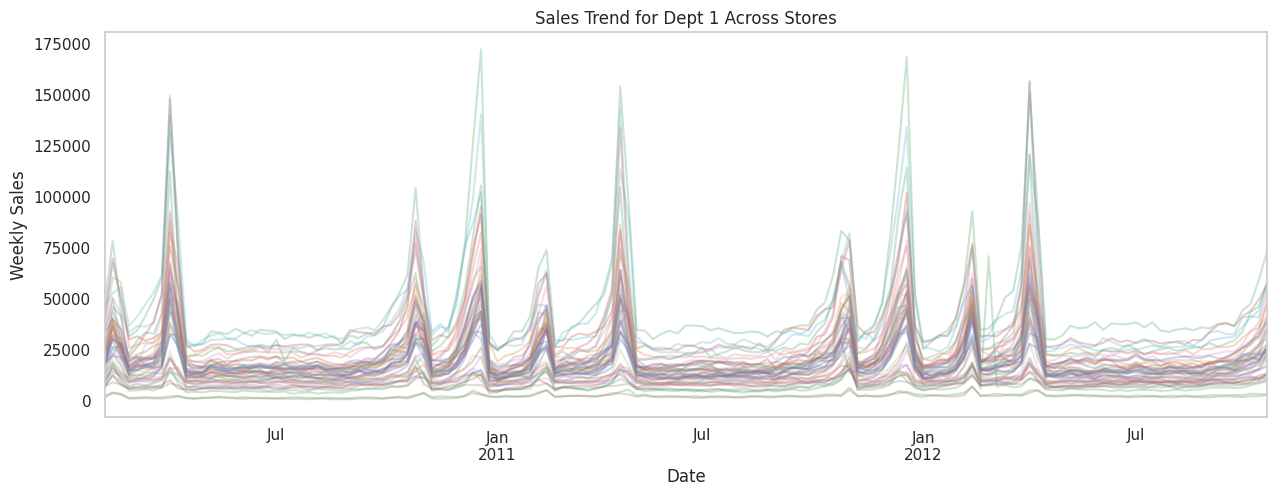

In [ ]:
# Plot for a common department (e.g., Dept 1)
dept_sales = train[train['Dept'] == 1].groupby(['Date', 'Store'])['Weekly_Sales'].sum().unstack()

dept_sales.plot(figsize=(15, 5), alpha=0.3, legend=False)
plt.title("Sales Trend for Dept 1 Across Stores")
plt.ylabel("Weekly Sales")
plt.grid()
plt.show()


# **Store size strongly correlates with sales scale, meaning sales differences are mostly structural — not behavioral.**

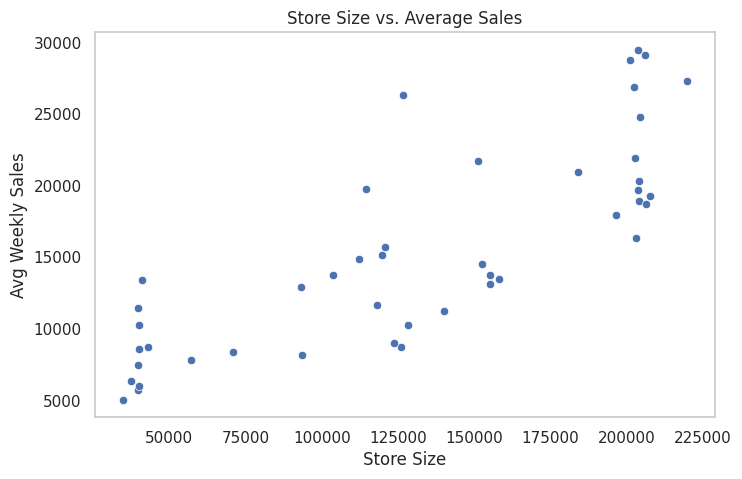

In [ ]:
store_avg_sales = train.groupby('Store')['Weekly_Sales'].mean()
store_sizes = stores.set_index('Store')['Size']

plt.figure(figsize=(8, 5))
sns.scatterplot(x=store_sizes, y=store_avg_sales)
plt.title("Store Size vs. Average Sales")
plt.xlabel("Store Size")
plt.ylabel("Avg Weekly Sales")
plt.grid()
plt.show()


# **Strong autocorrelations at 1 to 4-week lags suggest recent sales are highly predictive of current sales.**

Sales in retail often follow predictable patterns where this week's sales are correlated with previous weeks. Lag-1 (Previous Week): Captures short-term trends and immediate sales momentum
Lag-4 (4 weeks ago): Captures monthly seasonality patterns
Lag-52 (Same week last year): Captures annual seasonality - crucial for retail where holidays, back-to-school, etc. repeat yearly

ავტოკორელაციის ანალიზი აჩვენებს ძლიერ მოკლევადიან დამოკიდებულებებს (1-4 კვირა) და წლიურ სეზონურობას (52 კვირა). ეს ნიშნავს, რომ უახლოესი გაყიდვების ისტორია მნიშვნელოვანია მომავალი პროგნოზირებისთვის. ამიტომ ხეებში ხელსაყრელი იქნება ლეგ ფიჩერები: 1, 2, 3, 4 და 52 კვირის ლეგები  პროგნოზირებისთვის.


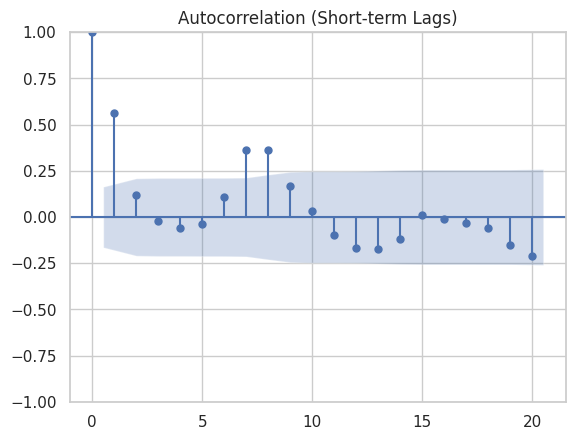

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

sample = train[(train['Store'] == 1) & (train['Dept'] == 1)].sort_values('Date')
ts = sample.set_index('Date')['Weekly_Sales'].asfreq('W-FRI')

plot_acf(ts.dropna(), lags=20)
plt.title("Autocorrelation (Short-term Lags)")
plt.show()


# **Lag-52 shows a similar pattern, highlighting the potential of yearly seasonality for SARIMA or feature engineering.**

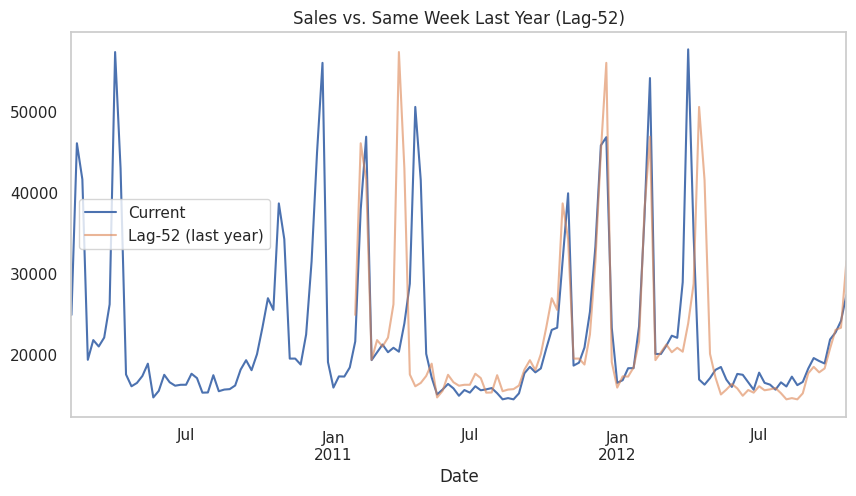

In [ ]:
ts = ts.dropna()
plt.figure(figsize=(10, 5))
ts.plot(label='Current')
ts.shift(52).plot(label='Lag-52 (last year)', alpha=0.6)
plt.legend()
plt.title("Sales vs. Same Week Last Year (Lag-52)")
plt.grid()
plt.show()


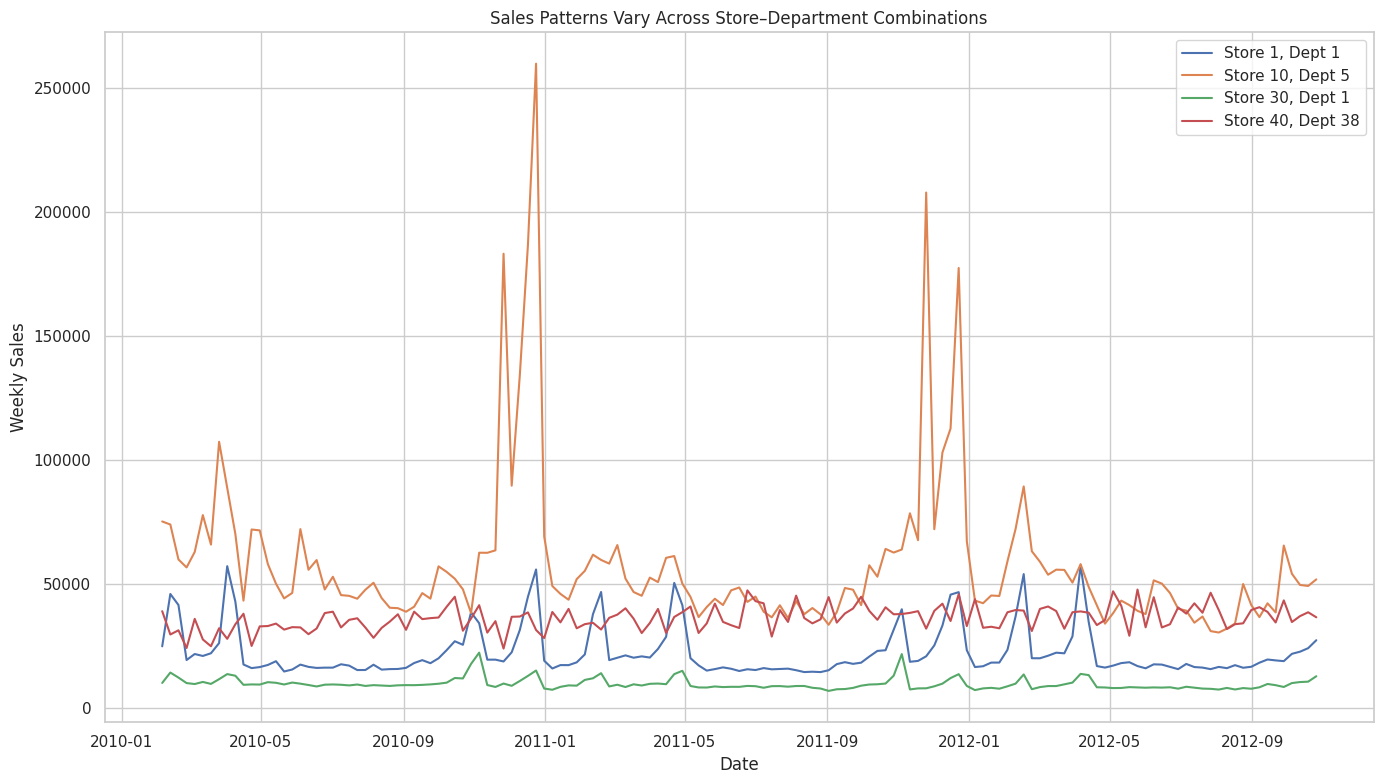

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few (Store, Dept) combinations to compare
store_dept_pairs = [(1, 1), (10, 5), (30, 1), (40, 38)]

plt.figure(figsize=(14, 8))

for store, dept in store_dept_pairs:
    ts = train[(train['Store'] == store) & (train['Dept'] == dept)]
    ts = ts.sort_values('Date')
    ts = ts.groupby('Date')['Weekly_Sales'].sum()

    plt.plot(ts.index, ts.values, label=f"Store {store}, Dept {dept}")

plt.title("Sales Patterns Vary Across Store–Department Combinations")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
